<a href="https://www.kaggle.com/code/ankitsingh1299/let-s-use-google-gemma?scriptVersionId=164033869" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <mark>How to use Google Gemma</mark>
<span style="font-size:22px;color:purple"> Thank you for having a look at my notebook - advice and feedback always welcomed!</span>

   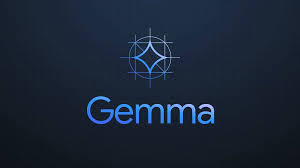

Google has released Gemma 2B and 7B, a pair of open-source AI models that let developers use the research that went into its flagship Gemini more freely. While Gemini is a big closed AI model that directly competes with (and is nearly as powerful as) OpenAI’s ChatGPT, the lightweight Gemma will likely be suitable for smaller tasks like simple chatbots or summarizations.

But what these models lack in complication, they may make up for in speed and cost of use. Despite their smaller size, Google claims Gemma models “surpass significantly larger models on key benchmarks” and are “capable of running directly on a developer laptop or desktop computer.” They will be available via Kaggle, Hugging Face, Nvidia’s NeMo, and Google’s Vertex AI. 



# Fine-tune Gemma models in Keras using LoRA

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://ai.google.dev/gemma/docs/lora_tuning"><img src="https://ai.google.dev/static/site-assets/images/docs/notebook-site-button.png" height="32" width="32" />View on ai.google.dev</a>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://console.cloud.google.com/vertex-ai/publishers/google/model-garden/335"><img src="https://ai.google.dev/images/cloud-icon.svg" width="40" />Open in Vertex AI</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/google/generative-ai-docs/blob/main/site/en/gemma/docs/lora_tuning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Overview

Gemma is a family of lightweight, state-of-the art open models built from the same research and technology used to create the Gemini models.

Large Language Models (LLMs) like Gemma have been shown to be effective at a variety of NLP tasks. An LLM is first pre-trained on a large corpus of text in a self-supervised fashion. Pre-training helps LLMs learn general-purpose knowledge, such as statistical relationships between words. An LLM can then be fine-tuned with domain-specific data to perform downstream tasks (such as sentiment analysis).

LLMs are extremely large in size (parameters in the order of millions). Full fine-tuning (which updates all the parameters in the model) is not required for most applications because typical fine-tuning datasets are relatively much smaller than the pre-training datasets.

[Low Rank Adaptation (LoRA)](https://arxiv.org/abs/2106.09685){:.external} is a fine-tuning technique which greatly reduces the number of trainable parameters for downstream tasks by freezing the weights of the model and inserting a smaller number of new weights into the model. This makes training with LoRA much faster and more memory-efficient, and produces smaller model weights (a few hundred MBs), all while maintaining the quality of the model outputs.

This tutorial walks you through using KerasNLP to perform LoRA fine-tuning on a Gemma 2B model using the [Databricks Dolly 15k dataset](https://www.kaggle.com/datasets/databricks/databricks-dolly-15k){:.external}. This dataset contains 15,000 high-quality human-generated prompt / response pairs specifically designed for fine-tuning LLMs.

## Setup

### Get access to Gemma

To complete this tutorial, you will first need to complete the setup instructions at [Gemma setup](https://ai.google.dev/gemma/docs/setup). The Gemma setup instructions show you how to do the following:

Gemma models are hosted by Kaggle. To use Gemma, request access on Kaggle:

- Sign in or register at [kaggle.com](https://www.kaggle.com)
- Open the [Gemma model card](https://www.kaggle.com/models/google/gemma) and select _"Request Access"_
- Complete the consent form and accept the terms and conditions


### Install dependencies

Install Keras, KerasNLP, and other dependencies.

## **Install and Import Libraries:**

In [1]:
# Install or upgrade the keras-nlp package
!pip install -U keras-nlp

# Install or upgrade the keras package
!pip install -U keras

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 465.2/465.2 kB 8.8 MB/s eta 0:00:00
  Attempting uninstall: keras-nlp
    Found existing installation: keras-nlp 0.7.0
    Uninstalling keras-nlp-0.7.0:
      Successfully uninstalled keras-nlp-0.7.0
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.8 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.15.0 requires keras<2.16,>=2.15.0, but you have keras 3.0.5 which is incompatible.
tensorflowjs 4.16.0 requires packaging~=23.1, but you have packaging 21.3 which is incompatible.


In [2]:
# Import the entire keras library
import keras

# Import the keras_nlp module
import keras_nlp

# Import the numpy library and alias it as np for convenience
import numpy as np

# Import the os module
import os

2024-02-23 17:51:15.574150: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-23 17:51:15.574267: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-23 17:51:15.705568: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
# Set the KERAS_BACKEND environment variable to "jax"
os.environ["KERAS_BACKEND"] = "jax"

**Explanation:**

1. `gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")`: Creates an instance of GemmaCausalLM from the preset "gemma_2b_en".

2. `gemma_lm.generate("Keras is a", max_length=30)`: Generates text with a single prompt "Keras is a" and a maximum length of 30.

3. `gemma_lm.generate(["Keras is a", "I want to say"], max_length=30)`: Generates text with batched prompts "Keras is a" and "I want to say", both having a maximum length of 30.

4. The generated text results are then printed to the console.

Keep in mind that the actual output will depend on the model's training data and the provided prompts. You may need to experiment with different prompts to explore the capabilities of the language model.

## **Load and Compile the Model:**

In [4]:
# Create an instance of GemmaCausalLM from the preset
gemma_lm = keras_nlp.models.GemmaCausalLM.from_preset("gemma_2b_en")

# Generate text with a single prompt
single_prompt_result = gemma_lm.generate("Keras is a", max_length=30)

# Print the result for the single prompt
print("Single Prompt Result:")
print(single_prompt_result)

Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'tokenizer.json' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
Attaching 'assets/tokenizer/vocabulary.spm' from model 'keras/gemma/keras/gemma_2b_en/2' to your Kaggle notebook...
normalizer.cc(51) LOG(INFO) precompiled_charsmap is empty. use identity normalization.
I0000 00:00:1708710773.495738      26 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
W0000 00:00:1708710773.558106      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update
W0000 00:00:1708710773.589318      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update

Single Prompt Result:
Keras is a popular deep learning library for Python. It is easy to use and has a wide range of features. One of the features of


In [5]:
# Generate text with batched prompts
batched_prompt_result = gemma_lm.generate(["Keras is a", "I want to say"], max_length=30)

# Print the result for the batched prompts
print("\nBatched Prompts Result:")
for result in batched_prompt_result:
    print(result)

W0000 00:00:1708710789.008820      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update



Batched Prompts Result:
Keras is a popular deep learning library for Python. It is easy to use and has a wide range of features. One of the features of
I want to say thank you to the staff at the <strong><em><u><strong><em><u><strong><em><u><strong><em><u><strong><em><u><strong><em>


In [6]:
# Assuming gemma_lm is a Keras model
gemma_lm.summary()

Preprocessor: "gemma_causal_lm_preprocessor"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Tokenizer (type)                                   ┃                                             Vocab # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ gemma_tokenizer (GemmaTokenizer)                   │                                             256,000 │
└────────────────────────────────────────────────────┴─────────────────────────────────────────────────────┘

Model: "gemma_causal_lm"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ padding_mask (InputLayer)     │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_ids (InputLayer)        │ (None, None)              │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ gemma_backbone                │ (None, None, 2048)        │   2,506,172,416 │ padding_mask[0][0],        │
│ (GemmaBackbone)               │                           │                 │ token_ids[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ token_embedding               │ (None, None, 256000)      │     524,288,000 │ gemma_backbone[0][0]       │
│ (ReversibleEmbedding)         │                           │                 │                            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 2,506,172,416 (9.34 GB)

 Trainable params: 2,506,172,416 (9.34 GB)

 Non-trainable params: 0 (0.00 B)

## **Generate text**

Now it's time to generate some text! The model has a generate method that generates text based on a prompt. The optional max_length argument specifies the maximum length of the generated sequence.

Try it out with the prompt "Why Rewa is famous?".

In [7]:
# Create an instance of GemmaCausalLM using the from_preset method
gemma_lm.generate("Why Rewa is famous?", max_length=150)              # REWA is my hometown that's why I asked to gemma, It is a city in the state of Madhya Pradesh, India.

'Why Rewa is famous?\n\nRewa is a city in the Indian state of Madhya Pradesh. It is the administrative headquarters of Rewa district. Rewa is famous for its Rewa Fort, which is a 17th-century fort built by the Rewa rulers. The fort is located on a hilltop and offers a panoramic view of the city. The fort is also home to a museum that showcases the history of the Rewa rulers.\n\nRewa is also famous for its Rewa mangoes, which are considered to be the best in the country. The mangoes are grown in the Rewa district and are known for their sweetness and flavour.\n\nRewa is also famous for its Rewa mangoes, which are considered to'

**Explanation:**

1. `prompt = "What is the meaning of life?"`: Defines the prompt for text generation. You can replace this with any prompt you'd like to use.

2. `generated_text = gemma_lm.generate(prompt)`: Uses the `generate` method of the `gemma_lm` instance to generate text based on the provided prompt.

3. `print(generated_text)`: Prints the generated text to the console.

Keep in mind that the quality and relevance of the generated text will depend on the pre-training of the GemmaCausalLM model and the chosen prompt. Feel free to experiment with different prompts to see how the model responds.



In [8]:
# Define the prompt
prompt = "What is the meaning of life?"

# Generate text based on the prompt
generated_text = gemma_lm.generate(prompt, max_length=64)

# Print the generated text
print(generated_text)

W0000 00:00:1708710829.344819      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


What is the meaning of life?

The question is one of the most important questions in the world.

It’s the question that has been asked by philosophers, theologians, and scientists for centuries.

And it’s the question that has been asked by people who are looking for answers to their own lives


In [9]:
gemma_lm.generate(
    ["What is the meaning of life?",
     "How does the brain work?"],            
    max_length=64)

W0000 00:00:1708710844.454334      26 graph_launch.cc:671] Fallback to op-by-op mode because memset node breaks graph update


['What is the meaning of life?\n\nThe question is one of the most important questions in the world.\n\nIt’s the question that has been asked by philosophers, theologians, and scientists for centuries.\n\nAnd it’s the question that has been asked by people who are looking for answers to their own lives',
 'How does the brain work?\n\nThe brain is the most complex organ in the human body. It is responsible for controlling all of the body’s functions, including breathing, heart rate, digestion, and more. The brain is also responsible for thinking, feeling, and making decisions.\n\nThe brain is made up']

**Optional: Try a different sampler**

You can control the generation strategy for GemmaCausalLM by setting the sampler argument on compile(). By default, "greedy" sampling will be used.

As an experiment, try setting a "top_k" strategy:


In [10]:
# Compile the GemmaCausalLM model with a sampler
gemma_lm.compile(sampler="top_k")

# Generate text based on a prompt
generated_text = gemma_lm.generate("Tell me intresting about Stock Market?", max_length=150)

In [11]:
# Print the generated text
print(generated_text)

Tell me intresting about Stock Market?
Stock Market is a place where people can buy and sell stocks. Stock markets are places where buyers and sellers of stocks meet to trade stocks.
Stock Market is a very interesting place to learn.
In the Stock Market, we buy shares of companies.
We sell those shares later to make a profit.
The price we pay for a share is called its <i><b>"Purchase Price"</b>.</i>
When we sell a share, we call the price we get when we sell the share <i>"Sale Price.</i>
When I buy a share, I pay the <i>Purchase Price.</i>
When I sell, I get the money I paid to buy it.



## **What's next**

* Learn how to finetune a Gemma model. https://ai.google.dev/gemma/docs/lora_tuning

* Learn how to perform distributed fine-tuning and inference on a Gemma model. https://ai.google.dev/gemma/docs/distributed_tuning

* Learn how to use Gemma models with Vertex AI.https://cloud.google.com/vertex-ai/docs/generative-ai/open-models/use-gemma

## **🚀 The best way to use Google Gemma 🚀**

Dear,

I hope this message finds you well.

**1. Cast Your Vote:**

Visit the competition platform and find my submissiona. Click on the "Vote" or "Support" button to cast your vote.

**2. Share with Your Network:**

Spread the word among your friends, family, and colleagues who may be interested in supporting my work.

**3. Provide Feedback:**

If you have any feedback or suggestions on my all notebooks, please feel free to share them with me. Your input is valuable and can help me improve. I am committed to making a positive impact in the field of Generative AI, and your support will bring me one step closer to achieving that goal.

Thank you for taking the time to read this message, and I genuinely appreciate your support. Together, we can contribute to the field of data-driven cutting edge & fast growing technology Artificial Intelligent.

If you have any questions or need more information about my Notebook, please don't hesitate to reach out to me. Your support means the world to me!



## **References**

* [Get started with Gemma using KerasNLP](https://www.kaggle.com/code/nilaychauhan/get-started-with-gemma-using-kerasnlp)
* [Fine-tune Gemma models in Keras using LoRA](https://www.kaggle.com/code/nilaychauhan/fine-tune-gemma-models-in-keras-using-lora)